## Talk 8: score-based diffusion models


In this notebook, we'll implement the *denoising score matching* objective.
Let $\Upsilon$ be the data distribution and let $\Upsilon_{\sigma}$ be the distribution of

$$ u + \eta, \qquad u \sim \Upsilon, \qquad \eta \sim p_{\sigma},$$

where $p_{\sigma}$ is the density of the Gaussian distribution $N(u, \sigma^{2})$.

The denoising score matching objective is:

$$ J(\theta) =  \mathbb{E}_{w \sim \Upsilon} \mathbb{E}_{u \sim p_{\sigma}} \left[ \| s_{\theta}(u) - \nabla_{u} \log p_{\sigma}(u)\|^{2} \right],$$

which, assuming $s_{\theta}$ is sufficiently flexible, is minimised when $s_{\theta} = \nabla \log \Upsilon_{\sigma}$.

Note that

$$ p_{\sigma}(u) = \frac{1}{(2\pi \sigma^{2})^{d/2}} \exp\left(-\frac{1}{2\sigma^{2}} \|w - u\|^{2}\right),$$

and so

$$\nabla_{u} \log p_{\sigma}(u) = - \frac{u - w}{\sigma^{2}} + \text{constant}, $$

so $J(\theta)$ can be evaluated just from $u$, $w$, and $s_{\theta}(u)$. 

To implement this, we will use **stochastic gradient descent** on the objective: in other words, we'll replace the expectation over $w \sim \Upsilon$ with a sum over a *minibatch* of training data $S = \{u_{i_{1}}, u_{i_{2}}, u_{i_{3}}, \dots, u_{i_{n}}\}$, and the expectation over $u \sim p_{\sigma}$ with a single draw from $p_{\sigma}$:

$$ \widehat{J}(\theta; S) = \sum_{i = 1}^{|S|} \left\|s_{\theta}(u_{i}) + \frac{w_{i} - u_{i}}{\sigma^{2}}\right\|^{2}, $$

where $w_{i} = u_{i} + \eta_{i}$, $\eta_{i} \overset{\text{i.i.d.}}{\sim} p_{\sigma}$. 

Then, at each step, we draw a new minibatch $S$ and update the parameters by

$$ \theta_{i + 1} = \theta_{i} - \nabla_{\theta} \widehat{J}(\theta; S). $$

> **Note**: To run this notebook you'll also need to install PyTorch and `tqdm` using Pip. See previous notebooks for the command needed.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, default_collate
from jax.tree_util import tree_map
from flax import linen as nn
from flax.training import train_state
from flax import struct
import optax
from tqdm import tqdm

First, we'll generate a data set in $X = \mathbb{R}^{2}$ with two clusters, given by the Gaussian mixture density

$$ \Upsilon(x) = \frac{1}{3\cdot 2\pi} \exp\left(\frac{\|x - \mu_{1}\|^{2}}{2}\right) + \frac{2}{3\cdot 2\pi} \exp\left(\frac{\|x - \mu_{2}\|^{2}}{2}\right) $$

with $\mu_{1} = (-10, 1)$ and $\mu_{2} = (10, 0)$.
We do this by generating $100$ points from the first Gaussian density and $200$ from the second (reflecting the $1/3$ to $2/3$ ratio in the density).

We'll then plot samples from $\Upsilon$ and its noised version $\Upsilon_{\sigma}$ with $\sigma = 3$.

> Note that the inputs to the training algorithm will be samples from $\Upsilon$, not $\Upsilon_{\sigma}$; the objective $J$ requires us to know both the unnoised data $u_{i}$ and the noised data $w_{i}$. Despite this, the result of training will be an algorithm that allows us to sample from $\Upsilon_{\sigma}$, not the distribution $\Upsilon$ of the training data. The hope is that $\Upsilon \approx \Upsilon_{\sigma}$ but this isn't guaranteed.

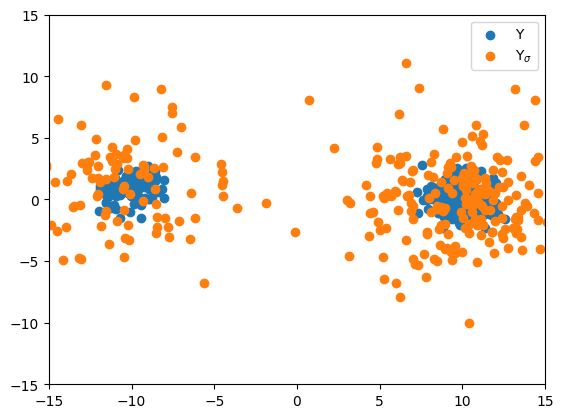

In [2]:
# Generate Gaussian mixure in R^2

SIGMA = 3

N_DATAPOINTS_1 = 100
MU_1 = np.array([-10, 1])

N_DATAPOINTS_2 = 200
MU_2 = np.array([10, 0])

X = np.vstack(
    [
        (MU_1 + np.random.randn(N_DATAPOINTS_1, 2)),
        (MU_2 + np.random.randn(N_DATAPOINTS_2, 2)),
    ]
)
plt.scatter(X[:, 0], X[:, 1], label=r"$\Upsilon$")
plt.xlim([-15, 15])
plt.ylim([-15, 15])

X_noised = X + np.random.randn(*X.shape) * SIGMA
plt.scatter(X_noised[:, 0], X_noised[:, 1], label=r"$\Upsilon_{\sigma}$")
plt.legend()

Now we'll convert this `numpy` array of data into a form that is easier to work with for `jax`.

> **Technical details**: to perform stochastic gradient descent, we would like to loop over minibatches from the data set. The PyTorch package has well-developed code to take a `numpy` array and convert it into a *data loader* that iterates over minibatches by drawing randomly without replacement. The data loader is just a Python iterator, so we can use a `for` loop to iterate over each batch in turn.

In [3]:
# `_numpy_collate` and `NumpyLoader` are based on the JAX notebook https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def _numpy_collate(batch):
    return tree_map(np.asarray, default_collate(batch))


class NumpyLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        num_workers=0,
        pin_memory=False,
        drop_last=False,
        timeout=0,
        worker_init_fn=None,
    ):

        # Batch_sampler option is mutually exclusive with
        # batch_size, shuffle, sampler, and drop_last.
        if batch_sampler is not None:
            additional_args = {}
        else:
            additional_args = {
                "batch_size": batch_size,
                "shuffle": shuffle,
                "drop_last": drop_last,
            }

        super(self.__class__, self).__init__(
            dataset,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=_numpy_collate,
            pin_memory=pin_memory,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            **additional_args,
        )


train_dataloader = NumpyLoader(X, batch_size=8, shuffle=True)

Now we'll set up the architecture for the score network $s_{\theta} \colon \mathbb{R}^{2} \to \mathbb{R}^{2}$. We'll use a simple neural network with two hidden layers of width 256.

> **Technical details**: we're using the `flax` package, which takes care of defining the weight and bias matrices behind the scenes. All we need to do is specify the `Dense` layers (the $Ax + b$) and the activation.

In [4]:
class ScoreNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=2)(x)
        return x

Next we'll set up the loss function $\widehat{J}(\theta; S)$ in `loss_fn`. 
This will be contained inside a larger function `train_step`, which:

- is given a minibatch of training data (in `batch`) and the current parameters (in `state`), as well as a *key* for the random number generator;

- wraps `loss_fn` in `jax.value_and_grad`, so that the resulting function `grad_fn` returns both the value of the loss and its gradient (with respect to `params`)

- evaluates the value `loss` and the gradients `grad` of the loss function

- performs stochastic gradient descent using `state.apply_gradients` (this is done behind the scenes using the `optax` package, but essentially just computes `params = params - learning_rate * grads`).


In [5]:
@jax.jit
def train_step(state, batch, key):
    # LOSS FUNCTION IS DEFINED HERE
    def loss_fn(params):
        noised_batch = batch + SIGMA * jax.random.normal(key)
        score = state.apply_fn({"params": params}, noised_batch)
        return jnp.sum((score + (noised_batch - batch) / SIGMA**2) ** 2)

    # Computes the value of the loss function, and the gradient with respect to
    # the parameters \theta.
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)

    # Uses the stochastic gradient descent (SGD) optimiser defined below to apply
    # the gradient update to the parameters \theta.
    state = state.apply_gradients(grads=grads)
    return state, loss


def create_train_state(module, rng, learning_rate):
    params = module.init(rng, jnp.ones([1, 2]))[
        "params"
    ]  # initialize parameters by passing a template image
    tx = optax.sgd(learning_rate)
    return train_state.TrainState.create(apply_fn=module.apply, params=params, tx=tx)

Now we'll initialise the score network, create the training state, and train for 1000 epochs (i.e., 1000 full loops over the training data). We use the `tqdm` package to get a nice-looking progress bar.

In [6]:
key = jax.random.PRNGKey(0)
s_theta = ScoreNetwork()
state = create_train_state(s_theta, key, learning_rate=1e-5)

EPOCHS = 1000

for epoch in range(EPOCHS):
    for step, batch in enumerate((pbar := tqdm(iter(train_dataloader)))):
        key, _ = jax.random.split(key)
        state, loss = train_step(state, batch, key)
        pbar.set_postfix_str(f"loss: {loss:.3f}")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
100%|██████████| 38/38 [00:00<00:00, 534.26it/s, loss: 0.143]


With the score function learned, we can use the *unadjusted Langevin algorithm* to sample from the distribution with score $s_{\theta}$. If indeed $s_{\theta} \approx \nabla \log \Upsilon_{\sigma}$, then this should result in samples approximately drawn from $\Upsilon_{\sigma}$.

The central idea is that the invariant distribution of the stochastic differential equation

$$ \frac{\mathrm{d} u}{\mathrm{d} t}  = s_{\theta} + \sqrt{2} \frac{\mathrm{d} W}{\mathrm{d} t}$$

is the distribution with score $s_{\theta}$, and thus if we simulate a path for large time $t$, the distribution of the path at the final time is approximately the target distribution.


We discretise the SDE using the Euler--Maruyama method.

The blue scatter points are true samples from $\Upsilon_{\sigma}$; the orange scatter points are independent realisations from Langevin dynamics truncated at a finite time step, with Gaussian initial condition.

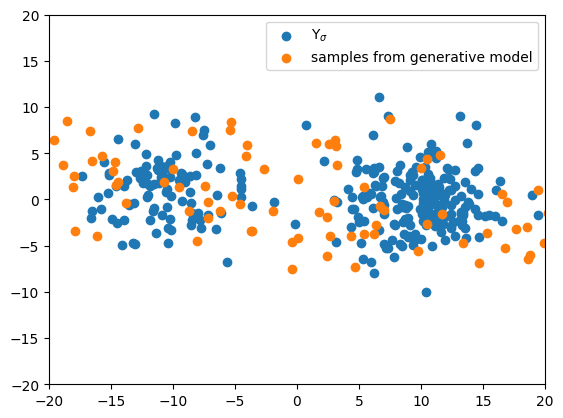

In [7]:
# Sample using Langevin dynamics


def langevin_sample(key, x0, params, step, n_steps):
    history = []

    @jax.jit
    def _inner(key, x):
        output = state.apply_fn({"params": params}, x)
        return (
            x
            + (step / 2) * output
            + jnp.sqrt(2 * step) * jax.random.normal(key, x.shape)
        )

    history = [x0]
    for i in range(0, n_steps):
        key, _ = jax.random.split(key)
        history.append(_inner(key, history[-1]))
    return history


N_SAMPLES = 100
x0 = np.random.randn(N_SAMPLES, 2)

x_sampled = langevin_sample(key, x0, state.params, 0.01, 10000)
plt.scatter(X_noised[:, 0], X_noised[:, 1], label=r"$\Upsilon_{\sigma}$")
plt.scatter(
    x_sampled[-1][:, 0], x_sampled[-1][:, 1], label="samples from generative model"
)
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.legend()

**Conclusions**: there is reasonable agreement between the two distributions, but the Langevin dynamicis samples seem to have much higher probability of staying near the origin. This is because there is very little data around $(0, 0)$, so estimates of the score are not that accurate.

The fix for this is described in the paper https://arxiv.org/pdf/1907.05600, which had significant impact in the machine-learning community. Their solution is to perform denoising score matching *at multiple noise scales simultaneously*, and then use *annealed Langevin dynamics* (start at high noise level and slowly decrease it when generating samples).

This then evolved into the paper https://arxiv.org/pdf/2011.13456, which can be essentially viewed as doing denoising score matching at infinitely many noise scales at once. These tricks are **essential** to get good performance, but we don't cover them in this notebook.

To illustrate the Langevin dynamics in more detail, we follow the path of a single simulation of Langevin dynamics starting at the origin, starting with black points at time $0$ and ending with red points at the final time:

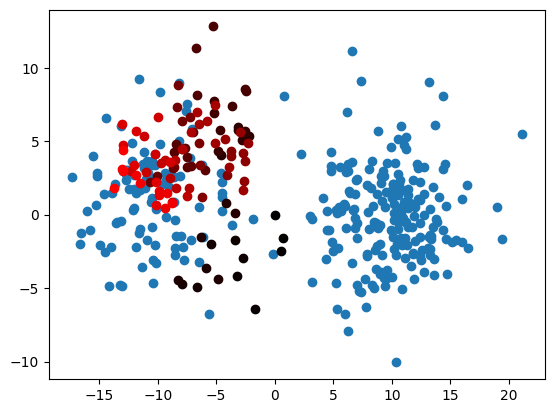

In [8]:
x0 = np.zeros((1, 2))
plot_frequency = 1000
n_steps = 100000
x_sampled = langevin_sample(key, x0, state.params, 0.001, n_steps)

plt.scatter(X_noised[:, 0], X_noised[:, 1])
for i, x in enumerate(x_sampled):
    if i % plot_frequency != 0:
        continue
    plt.scatter(x[:, 0], x[:, 1], color=(i / n_steps, 0, 0))